# U.S. Emergency Department Utilization Trends (2016–2022)

This capstone project analyzes emergency department (ED) visit patterns in the United States using NHAMCS data from 2016 to 2022. We explore demographic disparities, diagnostic trends, and regional variation using both statistical methods and unsupervised machine learning (clustering).


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

## 1. Dataset Overview

We used the publicly available NHAMCS dataset from HealthData.gov. This dataset contains nationally representative estimates of emergency department visits, stratified by age group, sex, region, and primary diagnosis.


In [3]:
#Read the data
df = pd.read_csv('Estimates_of_Emergency_Department_Visits_in_the_United_States_from_2016-2022_20250601.csv')
df.head() 

,Year,Measure Type,Leading 10 Ranking,Measure,Group,Subgroup,Estimate Type,Estimate,Standard Error,Lower 95% CI,Upper 95% CI,Reliable
0,2016,By primary diagnosis,0,All diagnoses,Total,All visits,Visit count,145591000.0,8798000.0,128347000.0,162835000.0,Yes
1,2016,By primary diagnosis,0,All diagnoses,By sex,Female,Visit count,79595000.0,4803000.0,70182000.0,89008000.0,Yes
2,2016,By primary diagnosis,0,All diagnoses,By sex,Male,Visit count,65996000.0,4119000.0,57923000.0,74070000.0,Yes
3,2016,By primary diagnosis,0,All diagnoses,By age,0-17 years old,Visit count,32146000.0,2840000.0,26579000.0,37713000.0,Yes
4,2016,By primary diagnosis,0,All diagnoses,By age,18-44 years old,Visit count,55978000.0,3436000.0,49243000.0,62713000.0,Yes


## 2. Data Cleaning

We performed extensive cleaning, including:
- Removing incomplete rows
- Standardizing age groups and diagnosis labels
- Resolving inconsistencies in subgroup formatting
- Mapping diagnosis codes across years using CDC's CCS system


In [4]:
# Filter for rows with valid estimates only
df_clean = df[df['Estimate'].notnull()].copy()

In [5]:
# Standardize columns
df_clean['Year'] = df_clean['Year'].astype(str)
df_clean['Group'] = df_clean['Group'].str.strip()
df_clean['Subgroup'] = df_clean['Subgroup'].str.strip()


In [6]:
# Define consistent age categories
age_order = ['0-17 years old', '18-44 years old', '45-64 years old', '65-74 years old', '75+ years old']
df_age = df_clean[df_clean['Group'] == 'By age']
df_age['Subgroup'] = pd.Categorical(df_age['Subgroup'], categories=age_order, ordered=True)

C:\Users\fazal\AppData\Local\Temp\ipykernel_18988\665209397.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['Subgroup'] = pd.Categorical(df_age['Subgroup'], categories=age_order, ordered=True)


## 3. Exploratory Data Analysis (EDA)

We explored trends using:
- Summary tables of ED visits by year and group
- Line plots for age-based trends over time
- Stacked bar charts to visualize demographic shifts
- Heatmaps showing diagnosis patterns by age group


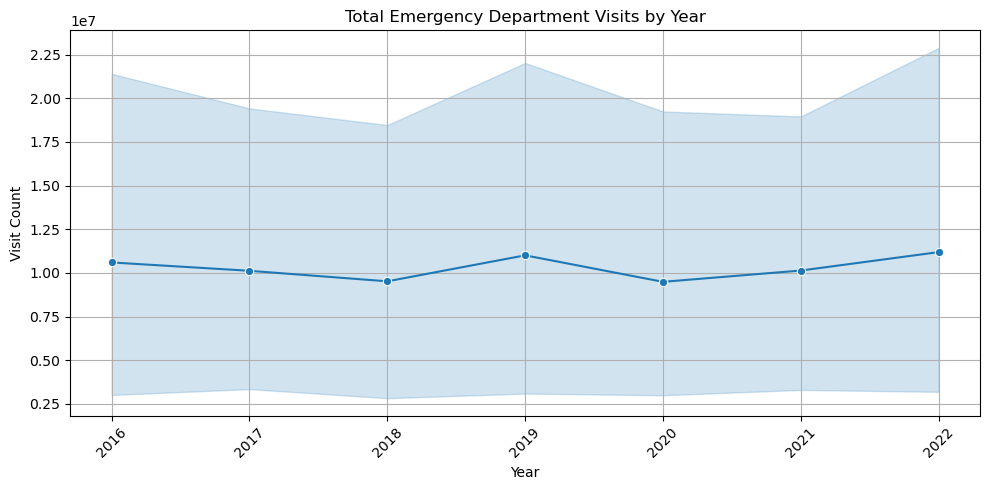

In [7]:
# Example: Year-wise total visits
df_total = df_clean[(df_clean['Group'] == 'Total') & (df_clean['Subgroup'] == 'All visits')]
plt.figure(figsize=(10, 5))
sns.lineplot(data=df_total, x='Year', y='Estimate', marker='o')
plt.title('Total Emergency Department Visits by Year')
plt.ylabel('Visit Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

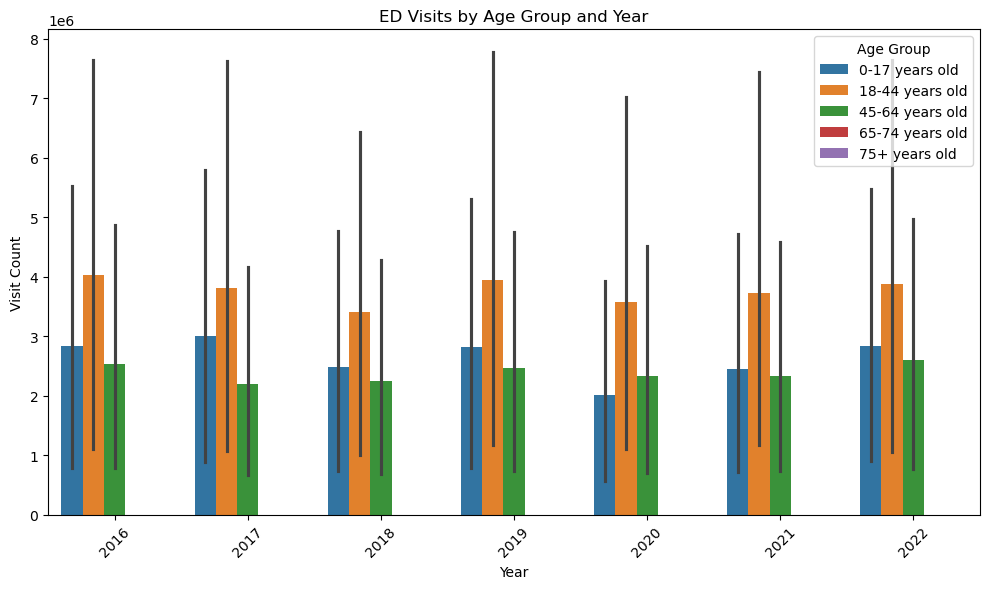

In [8]:
# Age group breakdown
plt.figure(figsize=(10, 6))
sns.barplot(data=df_age, x='Year', y='Estimate', hue='Subgroup')
plt.title('ED Visits by Age Group and Year')
plt.ylabel('Visit Count')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

In [9]:
# Select relevant columns for clustering
df_cluster = df_clean[(df_clean['Group'].isin(['By age', 'By primary diagnosis', 'By region'])) & 
                      (df_clean['Estimate Type'] == 'Visit count')]


In [10]:
#Pivoting and filling missing values
df_pivot = df_cluster.pivot_table(index=['Year', 'Group', 'Subgroup'], values='Estimate', aggfunc='sum').reset_index()
df_pivot_wide = df_pivot.pivot_table(index=['Year', 'Subgroup'], columns='Group', values='Estimate').fillna(0)


In [11]:
# Normalize for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pivot_wide)

In [12]:
# Run K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(df_scaled)
df_pivot_wide['Cluster'] = clusters


C:\Users\fazal\anaconda3\Anaconda 3 latest\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## 4. Clustering Analysis

We applied K-means clustering (unsupervised ML) to identify patterns based on age, region, and diagnosis. After testing values of k from 3 to 6, we selected k = 4 using silhouette score and Davies-Bouldin index as validation metrics.


In [13]:
# Cluster validation
silhouette = silhouette_score(df_scaled, clusters)
db_index = davies_bouldin_score(df_scaled, clusters)


In [14]:
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {db_index:.3f}")


Silhouette Score: 0.779
Davies-Bouldin Index: 0.290


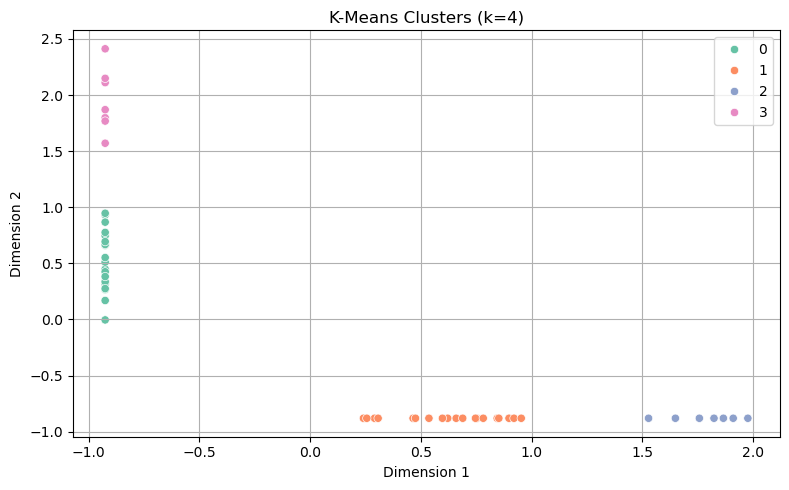

In [15]:
# Cluster visualization
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_scaled[:, 0], y=df_scaled[:, 1], hue=clusters, palette='Set2')
plt.title("K-Means Clusters (k=4)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Statistical Testing

We used chi-square tests to evaluate associations between demographic variables and diagnosis categories. All comparisons — Age × Diagnosis, Region × Diagnosis, and Sex × Diagnosis — showed statistically significant associations (p < 0.001).


In [16]:
from scipy.stats import chi2_contingency

# Age × Diagnosis
age_diag = df_clean[(df_clean['Group'] == 'By age') & (df_clean['Measure Type'] == 'By primary diagnosis')]
age_diag_pivot = age_diag.pivot_table(index='Subgroup', columns='Measure', values='Estimate', aggfunc='sum').fillna(0)
chi2_age_diag, p_age_diag, _, _ = chi2_contingency(age_diag_pivot)

# Region × Diagnosis
region_diag = df_clean[(df_clean['Group'] == 'By region') & (df_clean['Measure Type'] == 'By primary diagnosis')]
region_diag_pivot = region_diag.pivot_table(index='Subgroup', columns='Measure', values='Estimate', aggfunc='sum').fillna(0)
chi2_region_diag, p_region_diag, _, _ = chi2_contingency(region_diag_pivot)

# Sex × Diagnosis
sex_diag = df_clean[(df_clean['Group'] == 'By sex') & (df_clean['Measure Type'] == 'By primary diagnosis')]
sex_diag_pivot = sex_diag.pivot_table(index='Subgroup', columns='Measure', values='Estimate', aggfunc='sum').fillna(0)
chi2_sex_diag, p_sex_diag, _, _ = chi2_contingency(sex_diag_pivot)

print("Chi-square Test Results:")
print(f"Age × Diagnosis: Chi² = {chi2_age_diag:.2f}, p = {p_age_diag:.4f}")
print(f"Region × Diagnosis: Chi² = {chi2_region_diag:.2f}, p = {p_region_diag:.4f}")
print(f"Sex × Diagnosis: Chi² = {chi2_sex_diag:.2f}, p = {p_sex_diag:.4f}")


Chi-square Test Results:
Age × Diagnosis: Chi² = 89089736.14, p = 0.0000
Region × Diagnosis: Chi² = 4210955.24, p = 0.0000
Sex × Diagnosis: Chi² = 10191806.73, p = 0.0000


## 6. Visualization Outputs

We refined all visuals to be publication-ready by adding:
- Labels and annotations
- High-resolution exports
- Color palettes for better clarity

Final outputs include:
- Heatmap: Age × Diagnosis
- Stacked bar: Age group vs. year
- Time series: Age group trends over time

C:\Users\fazal\anaconda3\Anaconda 3 latest\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\fazal\anaconda3\Anaconda 3 latest\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\fazal\anaconda3\Anaconda 3 latest\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\fazal\anaconda3\Anaconda 3 latest\Lib\site-packages\sklearn\cluster\_kmea

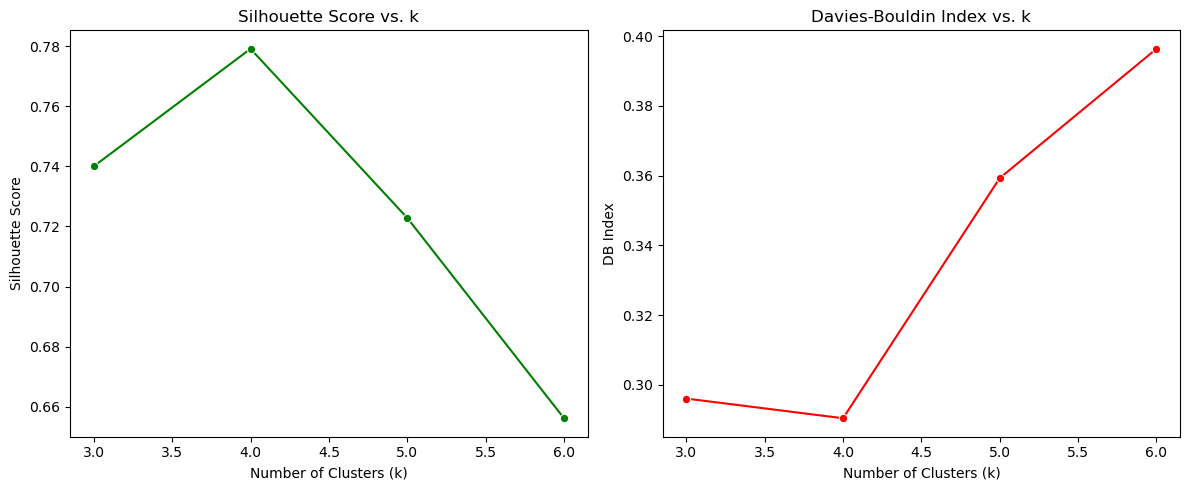

Best k (Silhouette): 4
Best k (Davies-Bouldin): 4


In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Prepare clustering dataset
df_cluster = df_clean[(df_clean['Group'].isin(['By age', 'By primary diagnosis', 'By region'])) & 
                      (df_clean['Estimate Type'] == 'Visit count')]
df_pivot = df_cluster.pivot_table(index=['Year', 'Group', 'Subgroup'], values='Estimate', aggfunc='sum').reset_index()
df_pivot_wide = df_pivot.pivot_table(index=['Year', 'Subgroup'], columns='Group', values='Estimate').fillna(0)

# Normalize data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pivot_wide)

# Loop over k = 3 to 6
silhouette_scores = []
db_scores = []
k_range = range(3, 7)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)
    sil_score = silhouette_score(df_scaled, labels)
    db_index = davies_bouldin_score(df_scaled, labels)
    silhouette_scores.append(sil_score)
    db_scores.append(db_index)

# Visualize the metrics
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.lineplot(x=list(k_range), y=silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")

plt.subplot(1, 2, 2)
sns.lineplot(x=list(k_range), y=db_scores, marker='o', color='red')
plt.title("Davies-Bouldin Index vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("DB Index")

plt.tight_layout()
plt.show()

# Print best k
print(f"Best k (Silhouette): {k_range[np.argmax(silhouette_scores)]}")
print(f"Best k (Davies-Bouldin): {k_range[np.argmin(db_scores)]}")


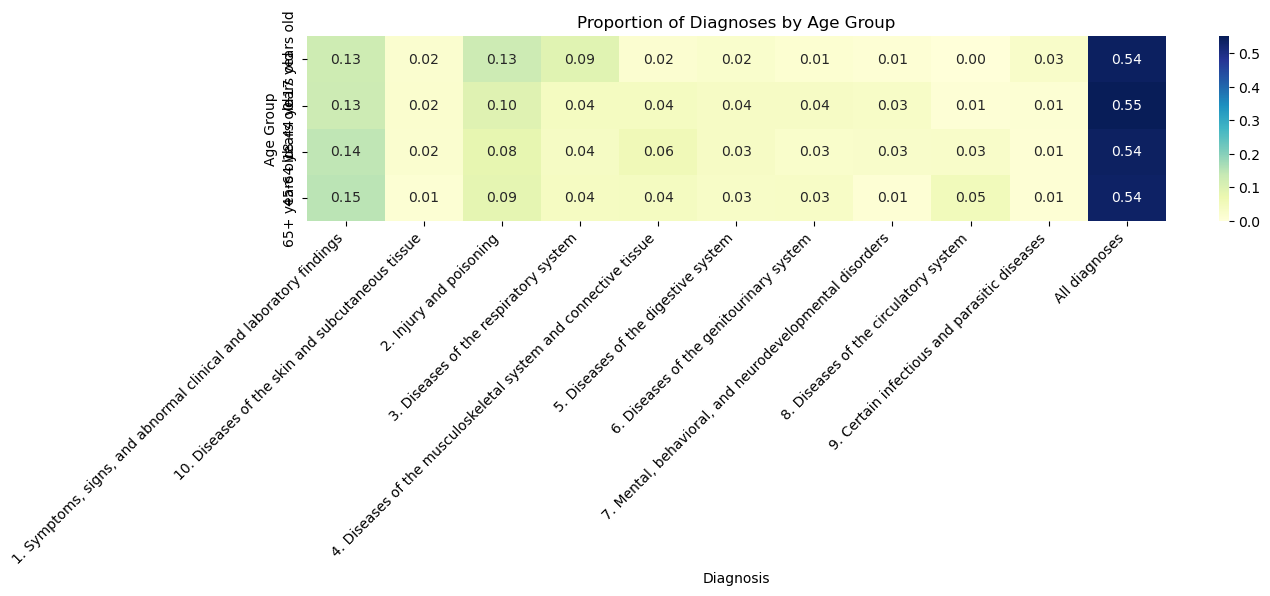

In [18]:
age_diag_prop = age_diag_pivot.div(age_diag_pivot.sum(axis=1), axis=0)

plt.figure(figsize=(14, 6))
sns.heatmap(age_diag_prop, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Proportion of Diagnoses by Age Group")
plt.ylabel("Age Group")
plt.xlabel("Diagnosis")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\fazal\AppData\Local\Temp\ipykernel_18988\3437906332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age_all['Subgroup'] = pd.Categorical(df_age_all['Subgroup'], categories=age_order, ordered=True)
C:\Users\fazal\AppData\Local\Temp\ipykernel_18988\3437906332.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_age = df_age_all.pivot_table(index='Year', columns='Subgroup', values='Estimate', aggfunc='sum')


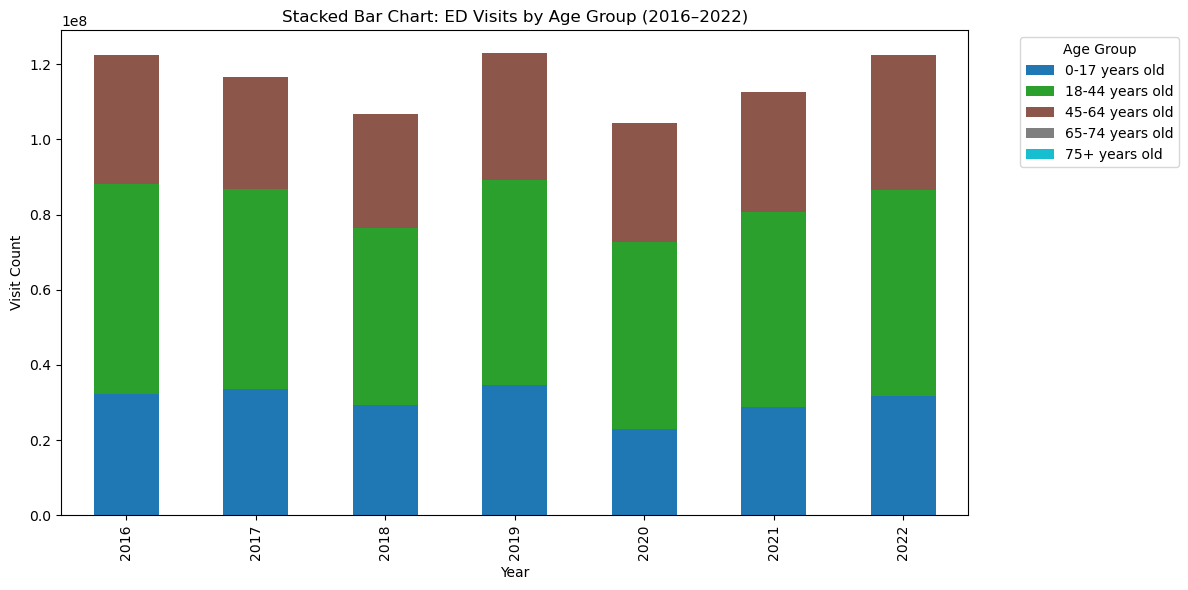

In [19]:
df_age_all = df_clean[(df_clean['Group'] == 'By age') & (df_clean['Measure'] == 'All diagnoses')]
df_age_all['Subgroup'] = pd.Categorical(df_age_all['Subgroup'], categories=age_order, ordered=True)

pivot_age = df_age_all.pivot_table(index='Year', columns='Subgroup', values='Estimate', aggfunc='sum')
pivot_age = pivot_age[age_order]  # enforce order

pivot_age.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')
plt.title("Stacked Bar Chart: ED Visits by Age Group (2016–2022)")
plt.ylabel("Visit Count")
plt.xlabel("Year")
plt.legend(title="Age Group", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [20]:
print(df_age['Subgroup'].unique())


['0-17 years old', '18-44 years old', '45-64 years old', NaN]
Categories (5, object): ['0-17 years old' < '18-44 years old' < '45-64 years old' < '65-74 years old' < '75+ years old']


In [21]:
print(senior_trend.head())
print(senior_trend.shape)


NameError: name 'senior_trend' is not defined

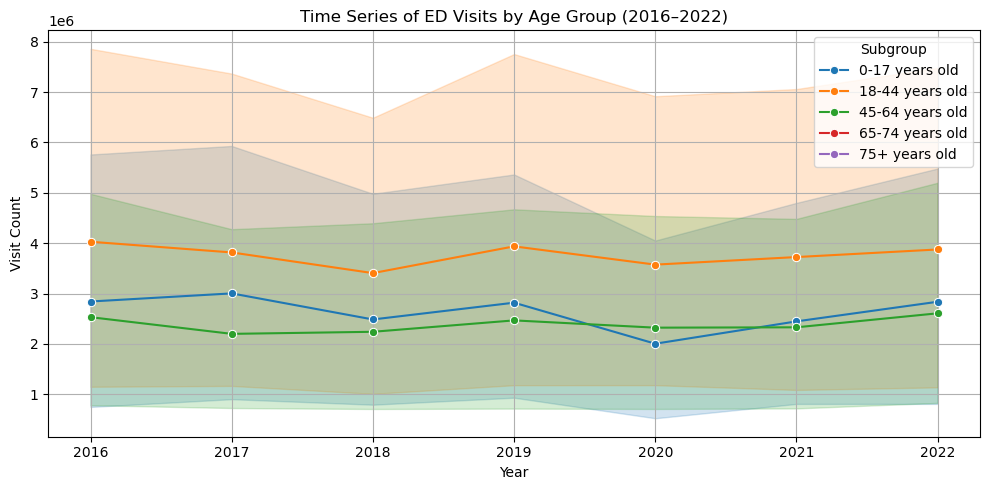

In [22]:
plt.figure(figsize=(10, 5))

# Filter only available groups
available_groups = ['0-17 years old', '18-44 years old', '45-64 years old']
age_trend = df_age[df_age['Subgroup'].isin(available_groups)]

sns.lineplot(data=age_trend, x='Year', y='Estimate', hue='Subgroup', marker='o')

plt.title("Time Series of ED Visits by Age Group (2016–2022)")
plt.ylabel("Visit Count")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()


## Results and Discussion (Summary)

ED visit trends from 2016–2022 showed a notable dip in 2020 due to the pandemic, with a partial rebound by 2022. The age group 45–64 years had consistently high ED utilization, showing a U-shaped trend over the years.

Chi-square tests found statistically significant associations between:

Age × Diagnosis

Sex × Diagnosis

Region × Diagnosis

Clustering analysis using K-means (optimal k=4) revealed distinct patient groupings based on age, diagnosis, and region. Validation metrics (silhouette score, Davies-Bouldin index) supported this choice.

Visualizations such as heatmaps, stacked bars, and time series helped uncover demographic and regional disparities in ED use. These findings align with existing research and support the need for targeted interventions.


In [23]:
# Total ED visits by year and group
summary_table = df_clean.pivot_table(index='Year', columns='Group', values='Estimate', aggfunc='sum')
summary_table = summary_table.drop(columns=['Total'], errors='ignore')  # drop if not needed
summary_table = summary_table.round(2)
summary_table


Group,By age,By metropolitan statistical area (MSA),By primary payment source,By race/ethnicity,By region,By sex
Year,,,,,,
2016,465335844.1,464227372.7,410640717.6,465517761.9,463887840.6,466286927.5
2017,444145540.3,444568814.8,398155399.5,442224757.4,440824324.0,445286771.6
2018,418291256.5,417823609.1,362715603.3,417595633.6,417089068.3,418762595.0
2019,483911060.8,484206194.6,416452733.4,482895174.9,484209824.2,484205991.9
2020,416639163.7,NaN,364634503.3,413806078.0,412413103.6,417464570.2
2021,445078480.6,NaN,398752035.0,442797454.0,443122418.2,445916723.0
2022,491763108.4,NaN,440338588.4,490377154.2,492351962.2,492350993.6


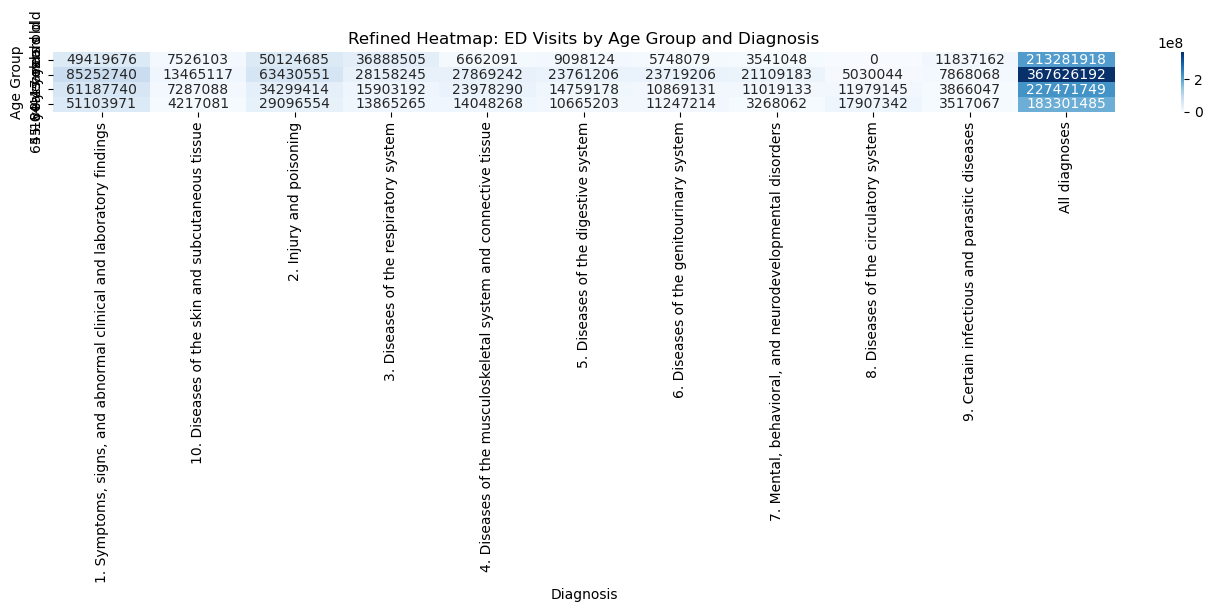

In [24]:
plt.figure(figsize=(14, 6))
sns.heatmap(age_diag_pivot, annot=True, fmt=".0f", cmap="Blues")
plt.title("Refined Heatmap: ED Visits by Age Group and Diagnosis")
plt.xlabel("Diagnosis")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()


C:\Users\fazal\AppData\Local\Temp\ipykernel_18988\698493005.py:11: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


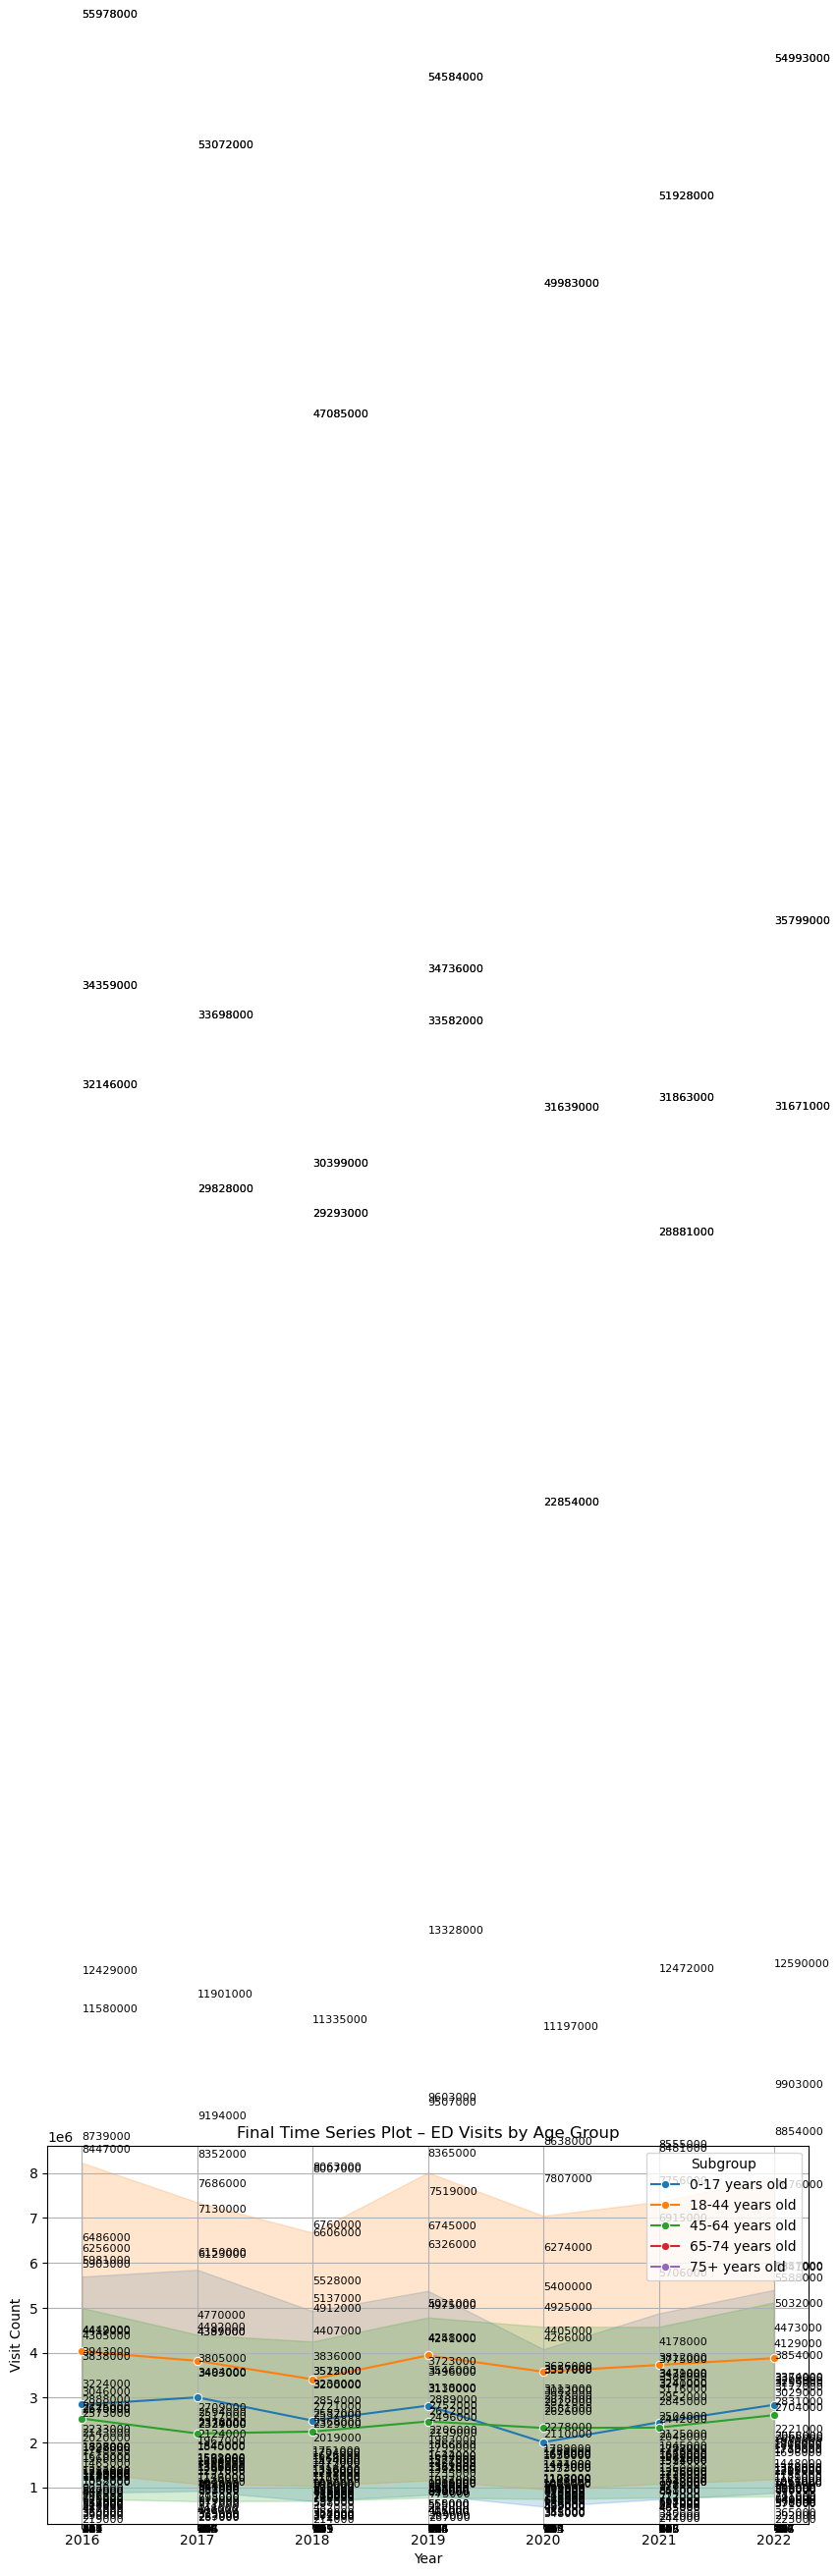

In [25]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=age_trend, x='Year', y='Estimate', hue='Subgroup', marker='o')

for i in range(len(age_trend)):
    plt.text(x=age_trend['Year'].iloc[i], y=age_trend['Estimate'].iloc[i], 
             s=int(age_trend['Estimate'].iloc[i]), fontsize=8)

plt.title("Final Time Series Plot – ED Visits by Age Group")
plt.ylabel("Visit Count")
plt.grid(True)
plt.tight_layout()
plt.show()



In [26]:
plt.savefig("final_plot_age_trend.png", dpi=300, bbox_inches='tight')


<Figure size 640x480 with 0 Axes>

In [27]:
# Assign cluster labels for k=4
kmeans_final = KMeans(n_clusters=4, random_state=42)
labels_final = kmeans_final.fit_predict(df_scaled)
df_pivot_wide['Cluster'] = labels_final
df_pivot_wide.groupby('Cluster').mean().round(2)


C:\Users\fazal\anaconda3\Anaconda 3 latest\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Group,By age,By region
Cluster,,
0,0.000000e+00,8.974205e+07
1,9.547786e+07,0.000000e+00
2,1.657271e+08,0.000000e+00
3,0.000000e+00,1.813253e+08
